# Capital Asset Pricing Model (CAPM)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
industry_portfolios = pd.read_excel('Industry_Portfolios.xlsx')
market_portfolio = pd.read_excel('Market_Portfolio.xlsx')

/Users/ciel/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
industry_portfolios = industry_portfolios.set_index('Date') 
industry_portfolios.head(2)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16


In [4]:
market_portfolio = market_portfolio.set_index('Date')
market_portfolio.head(2)

,Market
Date,
200401,2.22
200402,1.46


### OLS Regression for Market Model

>**Create dataset of excess returns of the market portfolio and industry portfolios**

In [5]:
Rf = 0.13
excess_return = pd.concat([market_portfolio['Market'] - Rf, industry_portfolios - Rf], axis = 1)
excess_return.head(2)

,Market,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,
200401,2.09,-0.07,-1.2,-0.75,0.31,4.40,1.28,0.32,2.96,1.79,2.75
200402,1.33,4.12,-0.2,1.82,4.56,-3.05,-0.65,5.96,0.76,1.94,2.03


> **Regress and create a table of the intercept and slope coefficients for the industry portfolios**

In [6]:
alpha = []
beta = []

# Function for regression and return coefficient
def linear_regression(independent_variable):
    x = sm.add_constant(excess_return['Market'])
    MODEL = sm.OLS(excess_return[independent_variable], x).fit()
    #print(MODEL.summary())
    alpha.append(MODEL.params[0])
    beta.append(MODEL.params[1])
    return alpha, beta

#Run OLS regression and generate the table of the intercept and slope coefficient
for portfolio in industry_portfolios.columns:
    linear_regression(portfolio)

coefficient = pd.DataFrame([alpha, beta], index = ['alpha', 'beta'], columns = industry_portfolios.columns)
coefficient

/Users/ciel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
alpha,0.369443,-0.415599,0.159771,0.501719,-0.064020,0.194691,0.275492,0.237841,0.444585,-0.387135
beta,0.652647,1.648536,1.169846,0.969850,1.132969,0.900729,0.826492,0.673036,0.538086,1.207309


**Economic Significance of Coefficients**

- Intercept coefficient shows pricing error for the portfolio and cannot be explained by CAPM. If alpha > 0 means overprice, investors should buy the portfolio, and vice versa. 
- Slope coefficient estimate the beta in CAPM, measures the amount of exposure to market risk.

### OLS Regression for Security Market Line (SML)

> **Mean monthly returns of the market portfolio and industry portfolios**

In [7]:
portfolio = pd.concat([industry_portfolios, market_portfolio], axis = 1)
portfolio.mean()

NoDur     0.902833
Durbl     0.733333
Manuf     1.012833
Enrgy     1.231167
HiTec     0.766250
Telcm     0.881417
Shops     0.916333
Hlth      0.783833
Utils     0.907167
Other     0.489083
Market    0.748083
dtype: float64

>**Regress and get the intercept and slope coefficient of SML**

In [8]:
# Add the beta of market portfolio into the beta set
beta.append(1)

#Create a table for regression
sml_data = pd.DataFrame([list(portfolio.mean()), beta], index = ['portfolio', 'beta'], columns = portfolio.columns)

#Regress and print coefficients
x = sm.add_constant(sml_data.T['beta'])
SML = sm.OLS(sml_data.T['portfolio'], x).fit()
print(SML.params)

const    1.032768
beta    -0.185467
dtype: float64


/Users/ciel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


>**SML Visualization**

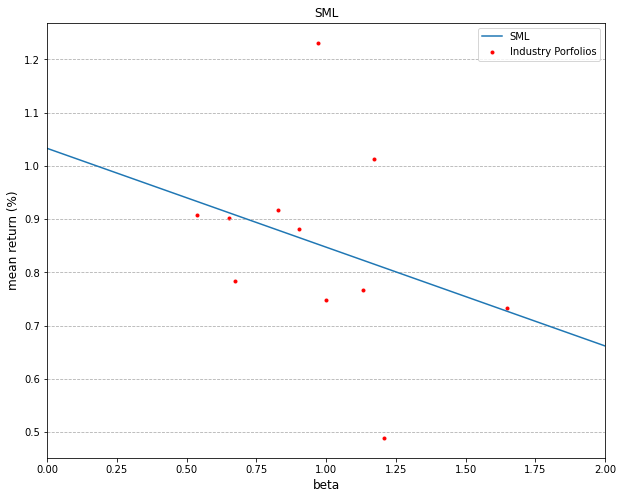

In [9]:
beta = np.arange(0, 2.1, 0.1)
mean_returns = []
for b in beta:
    Rp = SML.params[0] + SML.params[1] * b
    mean_returns.append(Rp)

plt.figure(figsize = (10, 8))
plt.plot(beta , mean_returns, label = 'SML')
plt.scatter('beta', 'portfolio', data = sml_data.T, marker = '.', color = 'r', label = 'Industry Porfolios')
plt.xlim(0, 2)
plt.title('SML')
plt.xlabel('beta', fontsize = 12)
plt.ylabel('mean return (%)', fontsize = 12)
plt.xlim(0, 2)
plt.grid(axis = 'y', linestyle = '--')
plt.legend()
plt.show()

**Ecomonic Significance of SML:**
- It shows the amount of risk premium for the given beta of portfolios or assets. If an asset lies above the line means overpricing, and vice versa. Over time, the market force will drive to market equilibrium, under which circumstances all assets and their combinations that can be created in a given financial market should lie on SML.